In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_olivetti_faces
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.pipeline import Pipeline
import warnings
warnings.filterwarnings('ignore')


## PART 1: Load, Split, and Cluster the Olivetti Faces Dataset


In [ ]:
print("="*70)
print("PART 1: CLUSTERING ANALYSIS")
print("="*70)

In [4]:
# Load the dataset
olivetti = fetch_olivetti_faces(shuffle=True, random_state=42)
X = olivetti.data  # Shape: (400, 4096)
y = olivetti.target  # Shape: (400,) - person IDs from 0 to 39
print(f"\nDataset shape: {X.shape}")
print(f"Number of unique people: {len(np.unique(y))}")
print(f"Images per person: {len(y) // len(np.unique(y))}")
print(f"Pixel value range: [{X.min():.2f}, {X.max():.2f}]")



Dataset shape: (400, 4096)
Number of unique people: 40
Images per person: 10
Pixel value range: [0.00, 1.00]


Split into train, validation, and test sets using stratified sampling

In [5]:
# First split: 60% train, 40% temp
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.4, stratify=y, random_state=42
)

# Second split: 20% validation, 20% test (from the 40% temp)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42
)

print(f"\nTrain set: {X_train.shape[0]} images")
print(f"Validation set: {X_val.shape[0]} images")
print(f"Test set: {X_test.shape[0]} images")


Train set: 240 images
Validation set: 80 images
Test set: 80 images


In [6]:
# Verify stratification
print(f"\nImages per person in train set: {np.bincount(y_train.astype(int))}")
print(f"Images per person in validation set: {np.bincount(y_val.astype(int))}")
print(f"Images per person in test set: {np.bincount(y_test.astype(int))}")


Images per person in train set: [6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6
 6 6 6]
Images per person in validation set: [2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2]
Images per person in test set: [2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2]


In [8]:
# Find optimal number of clusters using silhouette score
print("\n" + "-"*70)
print("Finding optimal number of clusters...")
print("-"*70)

k_range = range(40, 121, 10)  # Test from 40 to 120 clusters
silhouette_scores = []
inertias = []

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(X_train)
    silhouette = silhouette_score(X_train, cluster_labels, sample_size=1000)
    silhouette_scores.append(silhouette)
    inertias.append(kmeans.inertia_)
    print(f"k={k:3d}: Silhouette={silhouette:.4f}, Inertia={kmeans.inertia_:.0f}")



----------------------------------------------------------------------
Finding optimal number of clusters...
----------------------------------------------------------------------
k= 40: Silhouette=0.1423, Inertia=6788
k= 50: Silhouette=0.1597, Inertia=5859
k= 60: Silhouette=0.1726, Inertia=5180
k= 70: Silhouette=0.1783, Inertia=4508
k= 80: Silhouette=0.1889, Inertia=3927
k= 90: Silhouette=0.1902, Inertia=3414
k=100: Silhouette=0.1973, Inertia=2957
k=110: Silhouette=0.1933, Inertia=2560
k=120: Silhouette=0.1913, Inertia=2195


In [9]:

# Choose optimal k (using silhouette score)
optimal_k = k_range[np.argmax(silhouette_scores)]
print(f"\nOptimal number of clusters: {optimal_k}")

# Perform K-Means clustering with optimal k
print(f"\nClustering with k={optimal_k}...")
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
clusters = kmeans.fit_predict(X_train)


Optimal number of clusters: 100

Clustering with k=100...



Visualizing clusters...
Saved: olivetti_clusters_visualization.png


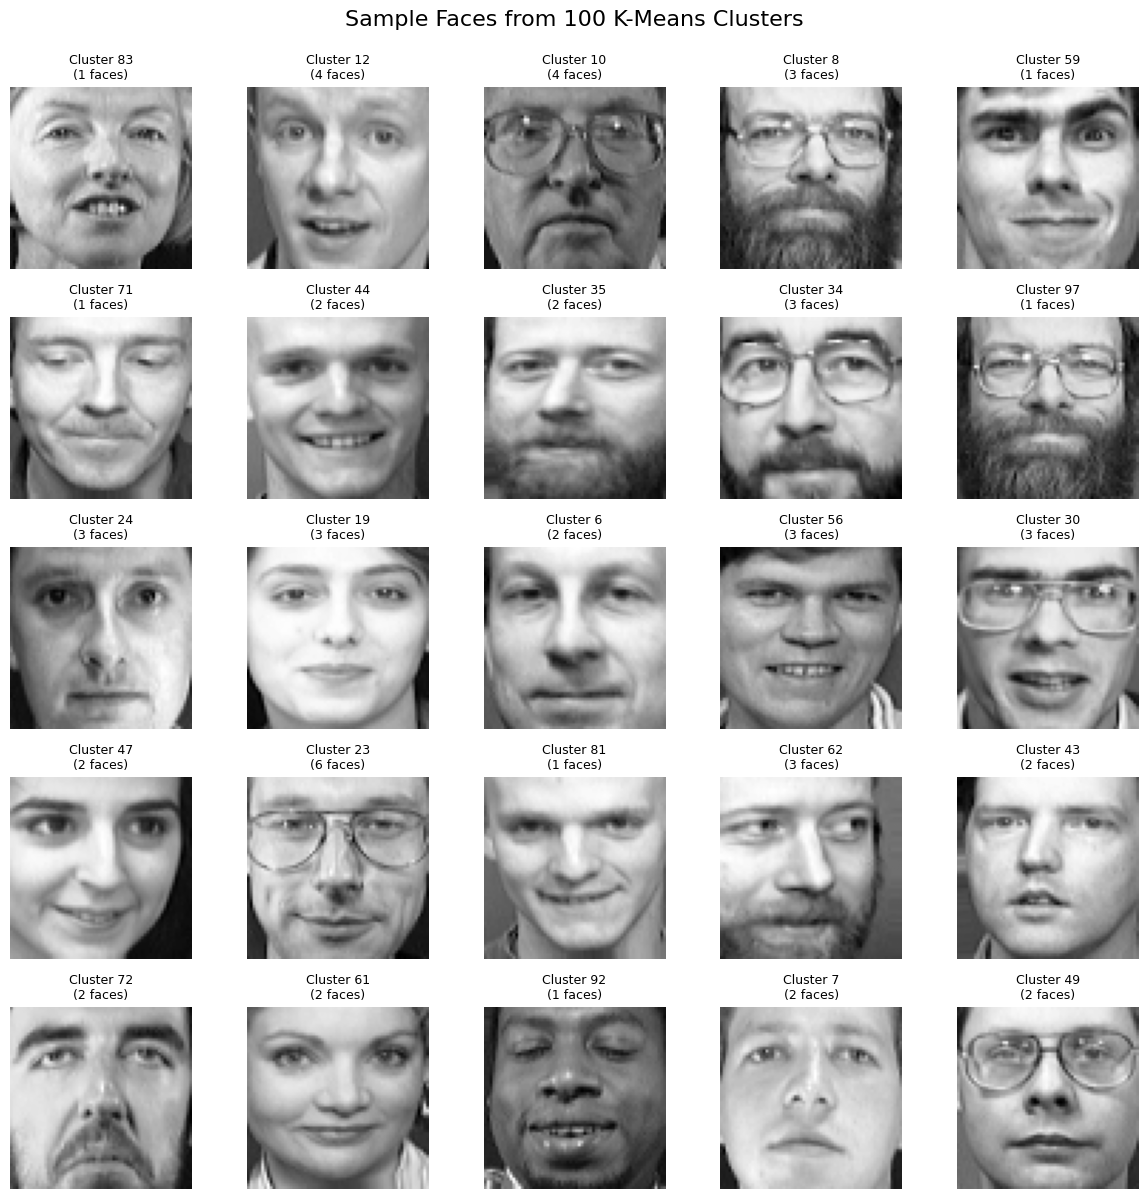

In [10]:
# Visualize clusters
print("\nVisualizing clusters...")
fig, axes = plt.subplots(5, 5, figsize=(12, 12))
fig.suptitle(f'Sample Faces from {optimal_k} K-Means Clusters', fontsize=16, y=0.995)

# Select 25 clusters to display
clusters_to_show = np.random.choice(optimal_k, size=min(25, optimal_k), replace=False)

for idx, (ax, cluster_id) in enumerate(zip(axes.ravel(), clusters_to_show)):
    # Get faces in this cluster
    cluster_faces = X_train[clusters == cluster_id]
    
    if len(cluster_faces) > 0:
        # Show first face from cluster
        face = cluster_faces[0].reshape(64, 64)
        ax.imshow(face, cmap='gray')
        ax.set_title(f'Cluster {cluster_id}\n({len(cluster_faces)} faces)', fontsize=9)
    ax.axis('off')

plt.tight_layout()
plt.savefig('olivetti_clusters_visualization.png', dpi=150, bbox_inches='tight')
print("Saved: olivetti_clusters_visualization.png")


Showing multiple faces from selected clusters...
Saved: olivetti_cluster_samples.png

----------------------------------------------------------------------
CLUSTER ANALYSIS
----------------------------------------------------------------------

Cluster sizes: min=1, max=6, mean=2.4


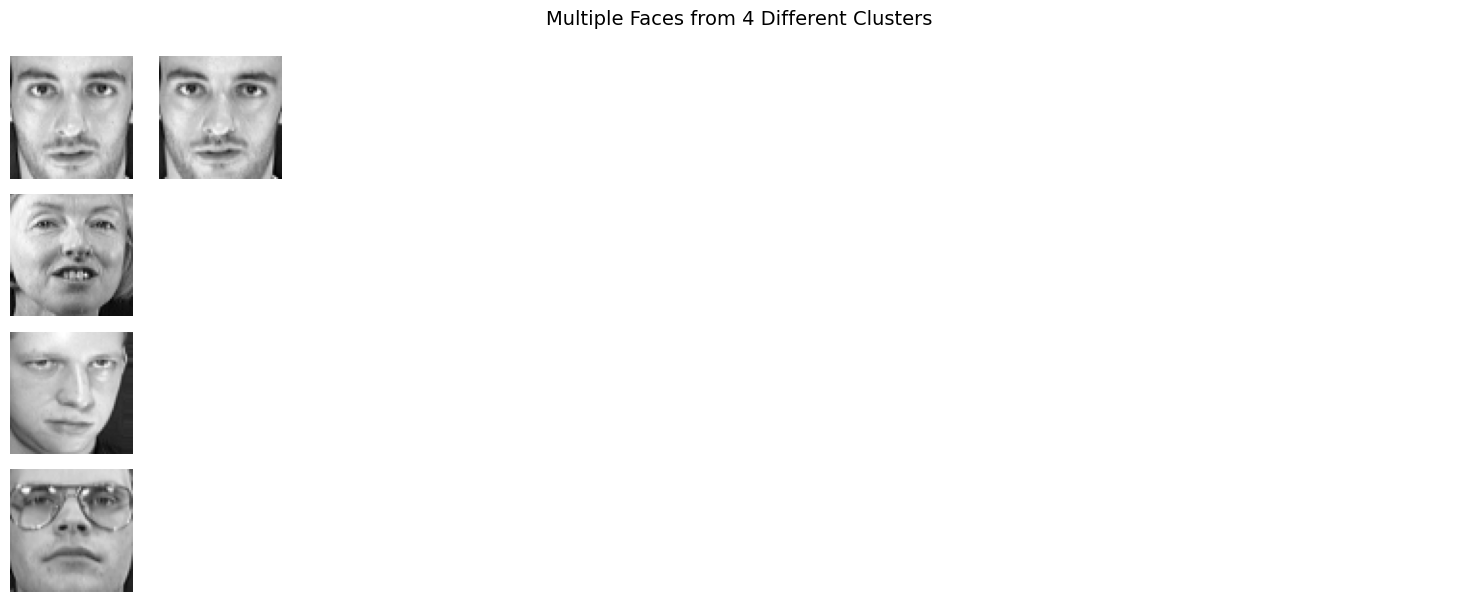

In [11]:
# Show multiple faces from a few selected clusters
print("\nShowing multiple faces from selected clusters...")
fig, axes = plt.subplots(4, 10, figsize=(15, 6))
fig.suptitle('Multiple Faces from 4 Different Clusters', fontsize=14, y=0.995)

selected_clusters = np.random.choice(optimal_k, size=4, replace=False)

for row_idx, cluster_id in enumerate(selected_clusters):
    cluster_faces = X_train[clusters == cluster_id]
    n_show = min(10, len(cluster_faces))
    
    for col_idx in range(10):
        ax = axes[row_idx, col_idx]
        if col_idx < n_show:
            face = cluster_faces[col_idx].reshape(64, 64)
            ax.imshow(face, cmap='gray')
            if col_idx == 0:
                ax.set_ylabel(f'Cluster {cluster_id}', fontsize=10, rotation=0, 
                            ha='right', va='center')
        ax.axis('off')

plt.tight_layout()
plt.savefig('olivetti_cluster_samples.png', dpi=150, bbox_inches='tight')
print("Saved: olivetti_cluster_samples.png")

# Analyze cluster composition
print("\n" + "-"*70)
print("CLUSTER ANALYSIS")
print("-"*70)
print(f"\nCluster sizes: min={np.bincount(clusters).min()}, "
      f"max={np.bincount(clusters).max()}, "
      f"mean={np.bincount(clusters).mean():.1f}")

In [12]:
# Check cluster purity (how many clusters contain faces from the same person)
cluster_purity = []
for cluster_id in range(optimal_k):
    cluster_labels = y_train[clusters == cluster_id]
    if len(cluster_labels) > 0:
        # Calculate purity as the proportion of most common label
        most_common = np.bincount(cluster_labels.astype(int)).max()
        purity = most_common / len(cluster_labels)
        cluster_purity.append(purity)

print(f"Average cluster purity: {np.mean(cluster_purity):.3f}")
print(f"Clusters with >50% same person: {sum(np.array(cluster_purity) > 0.5)}/{len(cluster_purity)}")

Average cluster purity: 0.950
Clusters with >50% same person: 93/100


# PART 2: Classification with and without K-Means Dimensionality Reduction

In [13]:
print("\n" + "="*70)
print("PART 2: CLASSIFICATION ANALYSIS")
print("="*70)

# Baseline: Train classifier on original features
print("\n" + "-"*70)
print("BASELINE: Classifier on Original Features")
print("-"*70)



PART 2: CLASSIFICATION ANALYSIS

----------------------------------------------------------------------
BASELINE: Classifier on Original Features
----------------------------------------------------------------------


In [14]:
clf_baseline = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
clf_baseline.fit(X_train, y_train)
y_pred_baseline = clf_baseline.predict(X_val)
baseline_accuracy = accuracy_score(y_val, y_pred_baseline)

print(f"\nBaseline Validation Accuracy: {baseline_accuracy:.4f}")


Baseline Validation Accuracy: 0.9500


In [15]:
# K-Means as dimensionality reduction
print("\n" + "-"*70)
print("K-MEANS DIMENSIONALITY REDUCTION")
print("-"*70)

k_values = [40, 60, 80, 100, 120, 150, 200]
reduction_results = []

print("\nTesting different numbers of clusters for dimensionality reduction...")
for k in k_values:
    # Use K-Means to transform features
    kmeans_reducer = KMeans(n_clusters=k, random_state=42, n_init=10)
    X_train_reduced = kmeans_reducer.fit_transform(X_train)
    X_val_reduced = kmeans_reducer.transform(X_val)
    
    # Train classifier on reduced features
    clf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
    clf.fit(X_train_reduced, y_train)
    y_pred = clf.predict(X_val_reduced)
    accuracy = accuracy_score(y_val, y_pred)
    
    reduction_results.append((k, accuracy))
    print(f"k={k:3d}: Validation Accuracy = {accuracy:.4f} "
          f"(Δ = {accuracy - baseline_accuracy:+.4f})")

best_k_reduction = max(reduction_results, key=lambda x: x[1])
print(f"\nBest k for dimensionality reduction: {best_k_reduction[0]} "
      f"(Accuracy: {best_k_reduction[1]:.4f})")


----------------------------------------------------------------------
K-MEANS DIMENSIONALITY REDUCTION
----------------------------------------------------------------------

Testing different numbers of clusters for dimensionality reduction...
k= 40: Validation Accuracy = 0.7750 (Δ = -0.1750)
k= 60: Validation Accuracy = 0.7625 (Δ = -0.1875)
k= 80: Validation Accuracy = 0.7750 (Δ = -0.1750)
k=100: Validation Accuracy = 0.7250 (Δ = -0.2250)
k=120: Validation Accuracy = 0.7625 (Δ = -0.1875)
k=150: Validation Accuracy = 0.8000 (Δ = -0.1500)
k=200: Validation Accuracy = 0.7875 (Δ = -0.1625)

Best k for dimensionality reduction: 150 (Accuracy: 0.8000)


In [16]:
# Augmented features: Original + K-Means distances
print("\n" + "-"*70)
print("AUGMENTED FEATURES: Original + K-Means Distances")
print("-"*70)

augmented_results = []

print("\nTesting augmented features with different numbers of clusters...")
for k in k_values:
    # Use K-Means to get distance features
    kmeans_augment = KMeans(n_clusters=k, random_state=42, n_init=10)
    X_train_kmeans = kmeans_augment.fit_transform(X_train)
    X_val_kmeans = kmeans_augment.transform(X_val)
    
    # Concatenate original features with K-Means distances
    X_train_augmented = np.hstack([X_train, X_train_kmeans])
    X_val_augmented = np.hstack([X_val, X_val_kmeans])
    
    # Train classifier on augmented features
    clf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
    clf.fit(X_train_augmented, y_train)
    y_pred = clf.predict(X_val_augmented)
    accuracy = accuracy_score(y_val, y_pred)
    
    augmented_results.append((k, accuracy))
    print(f"k={k:3d}: Validation Accuracy = {accuracy:.4f} "
          f"(Δ = {accuracy - baseline_accuracy:+.4f})")

best_k_augmented = max(augmented_results, key=lambda x: x[1])
print(f"\nBest k for augmented features: {best_k_augmented[0]} "
      f"(Accuracy: {best_k_augmented[1]:.4f})")



----------------------------------------------------------------------
AUGMENTED FEATURES: Original + K-Means Distances
----------------------------------------------------------------------

Testing augmented features with different numbers of clusters...
k= 40: Validation Accuracy = 0.9375 (Δ = -0.0125)
k= 60: Validation Accuracy = 0.9500 (Δ = +0.0000)
k= 80: Validation Accuracy = 0.9250 (Δ = -0.0250)
k=100: Validation Accuracy = 0.9375 (Δ = -0.0125)
k=120: Validation Accuracy = 0.9250 (Δ = -0.0250)
k=150: Validation Accuracy = 0.9375 (Δ = -0.0125)
k=200: Validation Accuracy = 0.9500 (Δ = +0.0000)

Best k for augmented features: 60 (Accuracy: 0.9500)


In [17]:
# Final evaluation on test set
print("\n" + "-"*70)
print("FINAL TEST SET EVALUATION")
print("-"*70)


----------------------------------------------------------------------
FINAL TEST SET EVALUATION
----------------------------------------------------------------------


In [18]:
# Test baseline
y_test_pred_baseline = clf_baseline.predict(X_test)
test_accuracy_baseline = accuracy_score(y_test, y_test_pred_baseline)
print(f"\nBaseline Test Accuracy: {test_accuracy_baseline:.4f}")


Baseline Test Accuracy: 0.9500


In [19]:
# Test best K-Means reduction
kmeans_best = KMeans(n_clusters=best_k_reduction[0], random_state=42, n_init=10)
X_train_best_reduced = kmeans_best.fit_transform(X_train)
X_test_best_reduced = kmeans_best.transform(X_test)

clf_best_reduced = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
clf_best_reduced.fit(X_train_best_reduced, y_train)
y_test_pred_reduced = clf_best_reduced.predict(X_test_best_reduced)
test_accuracy_reduced = accuracy_score(y_test, y_test_pred_reduced)
print(f"K-Means Reduction (k={best_k_reduction[0]}) Test Accuracy: {test_accuracy_reduced:.4f}")

K-Means Reduction (k=150) Test Accuracy: 0.8500


In [20]:
# Test best augmented
kmeans_best_aug = KMeans(n_clusters=best_k_augmented[0], random_state=42, n_init=10)
X_train_best_aug = np.hstack([X_train, kmeans_best_aug.fit_transform(X_train)])
X_test_best_aug = np.hstack([X_test, kmeans_best_aug.transform(X_test)])

clf_best_aug = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
clf_best_aug.fit(X_train_best_aug, y_train)
y_test_pred_aug = clf_best_aug.predict(X_test_best_aug)
test_accuracy_aug = accuracy_score(y_test, y_test_pred_aug)
print(f"Augmented Features (k={best_k_augmented[0]}) Test Accuracy: {test_accuracy_aug:.4f}")

Augmented Features (k=60) Test Accuracy: 0.9375



Creating performance comparison plot...


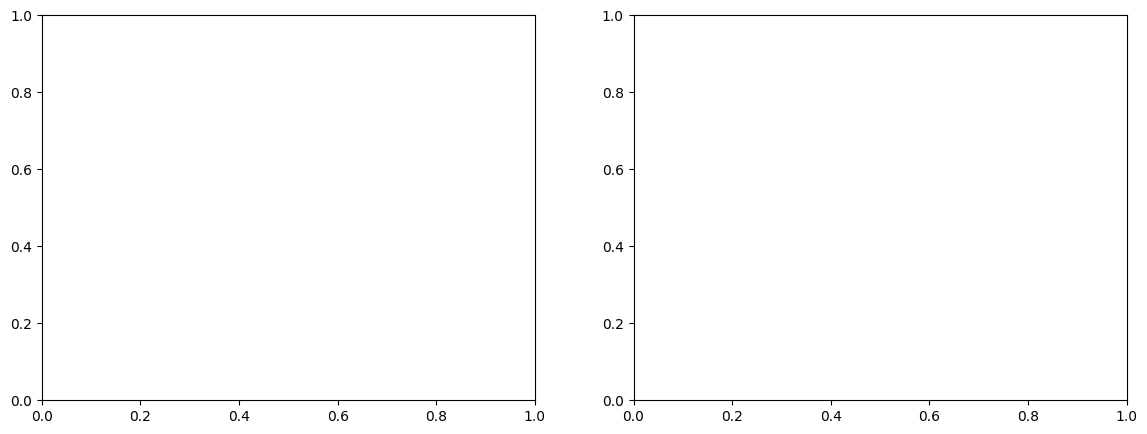

In [21]:
# Summary plot
print("\nCreating performance comparison plot...")
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))


In [22]:
# Plot 1: K-Means reduction performance
reduction_k = [r[0] for r in reduction_results]
reduction_acc = [r[1] for r in reduction_results]
ax1.plot(reduction_k, reduction_acc, 'o-', linewidth=2, markersize=8, label='K-Means Reduction')
ax1.axhline(y=baseline_accuracy, color='r', linestyle='--', linewidth=2, label='Baseline (No Reduction)')
ax1.set_xlabel('Number of Clusters (k)', fontsize=12)
ax1.set_ylabel('Validation Accuracy', fontsize=12)
ax1.set_title('K-Means as Dimensionality Reduction', fontsize=14, fontweight='bold')
ax1.legend(fontsize=10)
ax1.grid(True, alpha=0.3)
ax1.set_ylim([min(reduction_acc) - 0.02, max(reduction_acc) + 0.02])

(0.705, 0.8200000000000001)

In [24]:
# Plot 2: Augmented features performance
augmented_k = [r[0] for r in augmented_results]
augmented_acc = [r[1] for r in augmented_results]
ax2.plot(augmented_k, augmented_acc, 's-', linewidth=2, markersize=8, 
         label='Augmented Features', color='green')
ax2.axhline(y=baseline_accuracy, color='r', linestyle='--', linewidth=2, label='Baseline (Original Only)')
ax2.set_xlabel('Number of Clusters (k)', fontsize=12)
ax2.set_ylabel('Validation Accuracy', fontsize=12)
ax2.set_title('Original + K-Means Distance Features', fontsize=14, fontweight='bold')
ax2.legend(fontsize=10)
ax2.grid(True, alpha=0.3)
ax2.set_ylim([min(augmented_acc) - 0.02, max(augmented_acc) + 0.02])

plt.tight_layout()
plt.savefig('olivetti_classification_performance.png', dpi=150, bbox_inches='tight')
print("Saved: olivetti_classification_performance.png")

Saved: olivetti_classification_performance.png


<Figure size 640x480 with 0 Axes>

In [25]:
## Final summary
print("\n" + "="*70)
print("SUMMARY")
print("="*70)
print(f"\n1. Optimal number of clusters for visualization: {optimal_k}")
print(f"   - Silhouette score: {max(silhouette_scores):.4f}")
print(f"   - Average cluster purity: {np.mean(cluster_purity):.3f}")

print(f"\n2. Classification Performance (Validation Set):")
print(f"   - Baseline (original features): {baseline_accuracy:.4f}")
print(f"   - K-Means reduction (k={best_k_reduction[0]}): {best_k_reduction[1]:.4f} "
      f"(Δ = {best_k_reduction[1] - baseline_accuracy:+.4f})")
print(f"   - Augmented features (k={best_k_augmented[0]}): {best_k_augmented[1]:.4f} "
      f"(Δ = {best_k_augmented[1] - baseline_accuracy:+.4f})")

print(f"\n3. Final Test Set Performance:")
print(f"   - Baseline: {test_accuracy_baseline:.4f}")
print(f"   - K-Means reduction: {test_accuracy_reduced:.4f}")
print(f"   - Augmented features: {test_accuracy_aug:.4f}")

print("\n" + "="*70)
print("Analysis complete! Check the generated PNG files for visualizations.")
print("="*70)


SUMMARY

1. Optimal number of clusters for visualization: 100
   - Silhouette score: 0.1973
   - Average cluster purity: 0.950

2. Classification Performance (Validation Set):
   - Baseline (original features): 0.9500
   - K-Means reduction (k=150): 0.8000 (Δ = -0.1500)
   - Augmented features (k=60): 0.9500 (Δ = +0.0000)

3. Final Test Set Performance:
   - Baseline: 0.9500
   - K-Means reduction: 0.8500
   - Augmented features: 0.9375

Analysis complete! Check the generated PNG files for visualizations.
